<a href="https://colab.research.google.com/github/11kartheek/ERA-v2/blob/main/KartheekB_s10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [111]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [112]:
class CutoutAfterToTensor(object):
    def __init__(self, n_holes, length, fill_color=torch.tensor([0,0,0])):
        self.n_holes = n_holes
        self.length = length
        self.fill_color = fill_color

    def __call__(self, img):
        h = img.shape[1]
        w = img.shape[2]
        mask = numpy.ones((h, w), numpy.float32)
        for n in range(self.n_holes):
            y = numpy.random.randint(h)
            x = numpy.random.randint(w)
            y1 = numpy.clip(y - self.length // 2, 0, h)
            y2 = numpy.clip(y + self.length // 2, 0, h)
            x1 = numpy.clip(x - self.length // 2, 0, w)
            x2 = numpy.clip(x + self.length // 2, 0, w)
            mask[y1: y2, x1: x2] = 0.
        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask + (1 - mask) * self.fill_color[:, None, None]
        return img

In [113]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomCrop(32, padding=4),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       CutoutAfterToTensor(1,8)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.

                                       ])


# Dataset and Creating Train/Test Split

In [114]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [115]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=False) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The model
Let's start with the model we first saw

In [116]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1. prep layer
        self.prep = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        ) # output_size = 32

        # 2. layer 1
        # layer 1 x
        self.X1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        ) # output_size = 16

        # layer1 res
        self.R1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        ) # output_size = 16

        # 3. layer 2
        self.L2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3),  padding=1, bias=False),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        ) # output_size = 8

       # 4. layer 3
        # layer 3 x
        self.X2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), padding=1, bias=False),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        ) # output_size = 8

        # layer1 res
        self.R2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        ) # output_size = 8



        # 5 max pool
        self.pool1 = nn.MaxPool2d(4, 4)

        # 6 fc
        self.fc1 = nn.Linear(512, 10)


    def forward(self, x):
        # 1 prep
        x = self.prep(x)
        # 2
        x = self.X1(x)
        y = self.R1(x)
        x = x + y
        # 3
        x = self.L2(x)
        # 4
        x = self.X2(x)
        y = self.R2(x)
        x = x + y
        # 5 maxpool
        x = self.pool1(x)
        # 6 fc
        x = torch.flatten(x,1)
        x = self.fc1(x)
        # 7 softmax
        return F.log_softmax(x,1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [117]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [118]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.cross_entropy(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
from torch.optim.lr_scheduler import StepLR
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model =  Net().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

from torch.optim.lr_scheduler import OneCycleLR

LRMIN = 0.001
LRMAX = 1.07
total_epochs = 24
max_at_epoch = 5

# One Cycle Policy scheduler
scheduler = OneCycleLR(optimizer, max_lr=LRMAX, epochs=total_epochs,
                       steps_per_epoch=len(train_loader), pct_start=max_at_epoch/total_epochs, anneal_strategy='linear',
                       div_factor=LRMAX/LRMIN, final_div_factor=LRMAX/LRMIN)

EPOCHS = 24
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=1.2506154775619507 Batch_id=97 Accuracy=43.00: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]



Test set: Average loss: 1.2345, Accuracy: 5617/10000 (56.17%)

EPOCH: 1


Loss=0.9178747534751892 Batch_id=97 Accuracy=62.16: 100%|██████████| 98/98 [00:32<00:00,  3.03it/s]



Test set: Average loss: 1.0282, Accuracy: 6511/10000 (65.11%)

EPOCH: 2


Loss=0.8414233922958374 Batch_id=62 Accuracy=71.91:  64%|██████▍   | 63/98 [00:21<00:10,  3.40it/s]

In [120]:
!pip install torch-lr-finder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 622.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 3.9 MB/s eta 0:00:00


  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.07E+00


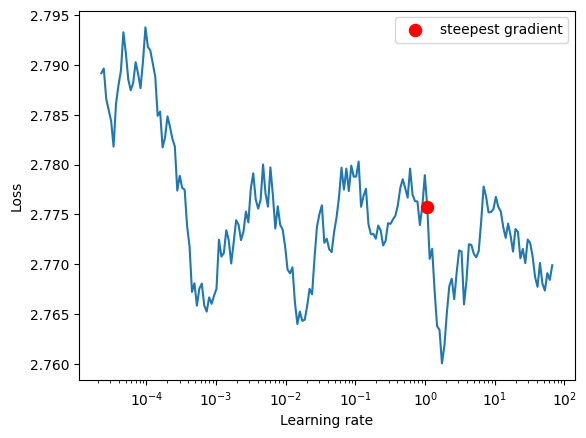

In [133]:
from torch_lr_finder import LRFinder
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
model =  Net().to(device)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=200)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset()

In [129]:
lr_finder.history

{'lr': [0.001,
  0.0011233240329780274,
  0.0012618568830660205,
  0.0014174741629268052,
  0.0015922827933410925,
  0.001788649529057435,
  0.002009233002565047,
  0.00225701971963392,
  0.002535364493970112,
  0.002848035868435802,
  0.0031992671377973833,
  0.003593813663804627,
  0.004037017258596554,
  0.004534878508128583,
  0.005094138014816379,
  0.0057223676593502176,
  0.006428073117284322,
  0.007220809018385464,
  0.008111308307896872,
  0.009111627561154892,
  0.010235310218990261,
  0.011497569953977358,
  0.012915496650148838,
  0.014508287784959396,
  0.01629750834620644,
  0.018307382802953687,
  0.02056512308348652,
  0.023101297000831595,
  0.025950242113997355,
  0.029150530628251764,
  0.03274549162877729,
  0.03678379771828635,
  0.04132012400115338,
  0.04641588833612778,
  0.05214008287999685,
  0.058570208180566664,
  0.06579332246575681,
  0.0739072203352578,
  0.08302175681319743,
  0.09326033468832198,
  0.10476157527896648,
  0.11768119524349985,
  0.132194